In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


## Load and inspect simulation data

In [2]:
import pandas
import seaborn
from scipy.stats import skew, entropy, kurtosis, gaussian_kde, pearsonr
from os import listdir
from SuchTree import SuchTree, SuchLinkedTrees
from pyprind import ProgBar

reading data, building graphs...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31


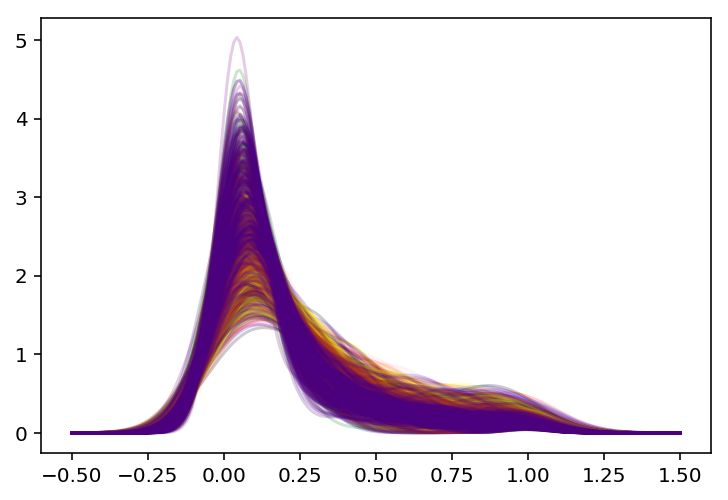

In [43]:
X = linspace( -0.5, 1.5, 200 )

path_noswitch_slow     = { 'path'  : 'simulations/noswitch_slow/',
                           'label' : 'noswitch_slow',
                           'switch': 'none',
                           'g_evol': 'slow',
                           'color' : 'red' }
path_noswitch_balanced = { 'path'  : 'simulations/noswitch_balanced/',
                           'label' : 'noswitch_balanced',
                           'switch': 'none',
                           'g_evol': 'balanced',
                           'color' : 'blue' }
path_noswitch_fast     = { 'path'  : 'simulations/noswitch_fast/',
                           'label' : 'noswitch_fast',
                           'switch': 'none',
                           'g_evol': 'fast',
                           'color' : 'green' }

path_slowswitch_slow     = { 'path'  : 'simulations/slowswitch_slow/',
                             'label' : 'slowswitch_slow',
                             'switch': 'slow',
                             'g_evol': 'slow',
                             'color' : 'pink' }
path_slowswitch_balanced = { 'path'  : 'simulations/slowswitch_balanced/',
                             'label' : 'slowswitch_balanced',
                             'switch': 'slow',
                             'g_evol': 'balanced',
                             'color' : 'black' }
path_slowswitch_fast     = { 'path'  : 'simulations/slowswitch_fast/',
                             'label' : 'slowswitch_fast',
                             'switch': 'slow',
                             'g_evol': 'fast',
                             'color' : 'purple' }

path_fastswitch_slow     = { 'path'  : 'simulations/fastswitch_slow/',
                             'label' : 'fastswitch_slow',
                             'switch': 'fast',
                             'g_evol': 'slow',
                             'color' : 'yellow' }
path_fastswitch_balanced = { 'path'  : 'simulations/fastswitch_balanced/',
                             'label' : 'fastswitch_balanced',
                             'switch': 'fast',
                             'g_evol': 'balanced',
                             'color' : 'brown' }
path_fastswitch_fast     = { 'path'  : 'simulations/fastswitch_fast/',
                             'label' : 'fastswitch_fast',
                             'switch': 'fast',
                             'g_evol': 'fast',
                             'color' : 'indigo' }

allsims = [ path_noswitch_slow,   path_noswitch_balanced,   path_noswitch_fast,
            path_slowswitch_slow, path_slowswitch_balanced, path_slowswitch_fast,
            path_fastswitch_slow, path_fastswitch_balanced, path_fastswitch_fast]

moments = []
data = []
spectra = []
SLTs = []
igraphs = []

p = ProgBar( sum( [ len(i) for i in [ listdir(sim['path']) for sim in allsims ] ] ),
             title='reading data, building graphs...' )

for sim in allsims :
    for run in listdir( sim['path'] ) :
        if run.endswith( '.log' ) : p.update(); continue
        
        sim['run'] = run
        path = sim['path'] + run + '/'
        
        # read the calculated eigenvalues, build density distribution
        eg = array( map( float, open( path + 'eigenvalues.csv').readline().split()[1].split(',') ) )
        density = gaussian_kde( eg/max(eg), bw_method=0.4 ).pdf( X )
        
        # read the calculated moments, build a DataFrame row
        moments.append( pandas.read_csv( path + 'moments.csv' ) )
        d = pandas.read_csv( path + 'data.csv' )
        d = pandas.DataFrame([sim]).join(d)
        data.append( d )
        
        # plot the spectral densities
        spectra.append( density )
        plot( X, density, color=sim['color'], alpha=0.2 )
        
        # build the graph objects
        T1 = SuchTree( path + 'host.relaxed.tree' )
        T2 = SuchTree( path + 'guest.relaxed.tree' )
        LK = pandas.read_csv( path + 'links.csv', index_col=0 )
        SLT = SuchLinkedTrees( T1, T2, LK )
        SLTs.append( SLT )
        igraphs.append( SLT.to_igraph() )
        
        p.update()
    
moments = pandas.concat( moments, ignore_index=True )
data = pandas.concat( data, ignore_index=True )

In [44]:
q = moments.join(data)
q.head()

,eigengap,skew,occupancy,treedist,p,r,squareness,kurtosis,color,g_evol,...,duplication_rate,prefix,guest_leafs,theta,k,loss_rate,min_guest_leafs,host_leafs,max_guest_leafs,max_host_leafs
0,0.179776,1.123630,1.000000,0.180138,0.197220,0.251218,1.000000,-0.046144,red,slow,...,0.0125,noswitch_slow/run39,8,0.5,2.0,0.0025,4,8,128,128
1,0.341961,0.794785,0.933333,0.150083,0.003365,0.609343,1.142857,-0.737914,red,slow,...,0.0125,noswitch_slow/run50,7,0.5,2.0,0.0025,4,8,128,128
2,0.610641,0.932618,0.769231,0.203625,0.474093,0.256665,1.600000,-0.416426,red,slow,...,0.0125,noswitch_slow/run149,5,0.5,2.0,0.0025,4,8,128,128
3,0.463081,1.111926,1.000000,0.247618,0.000180,0.650255,1.000000,-0.211371,red,slow,...,0.0125,noswitch_slow/run163,8,0.5,2.0,0.0025,4,8,128,128
4,0.101506,1.325231,1.000000,0.243475,0.022413,0.429901,1.000000,0.344731,red,slow,...,0.0125,noswitch_slow/run172,8,0.5,2.0,0.0025,4,8,128,128


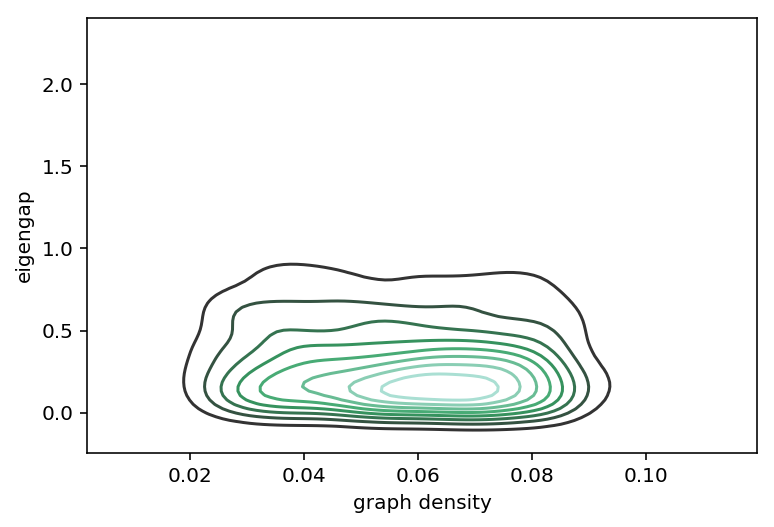

In [63]:
#scatter( q.occupancy, q.treedist )

seaborn.kdeplot( [ ig.density() for ig in igraphs ], q.eigengap )
xlabel( 'graph density' )

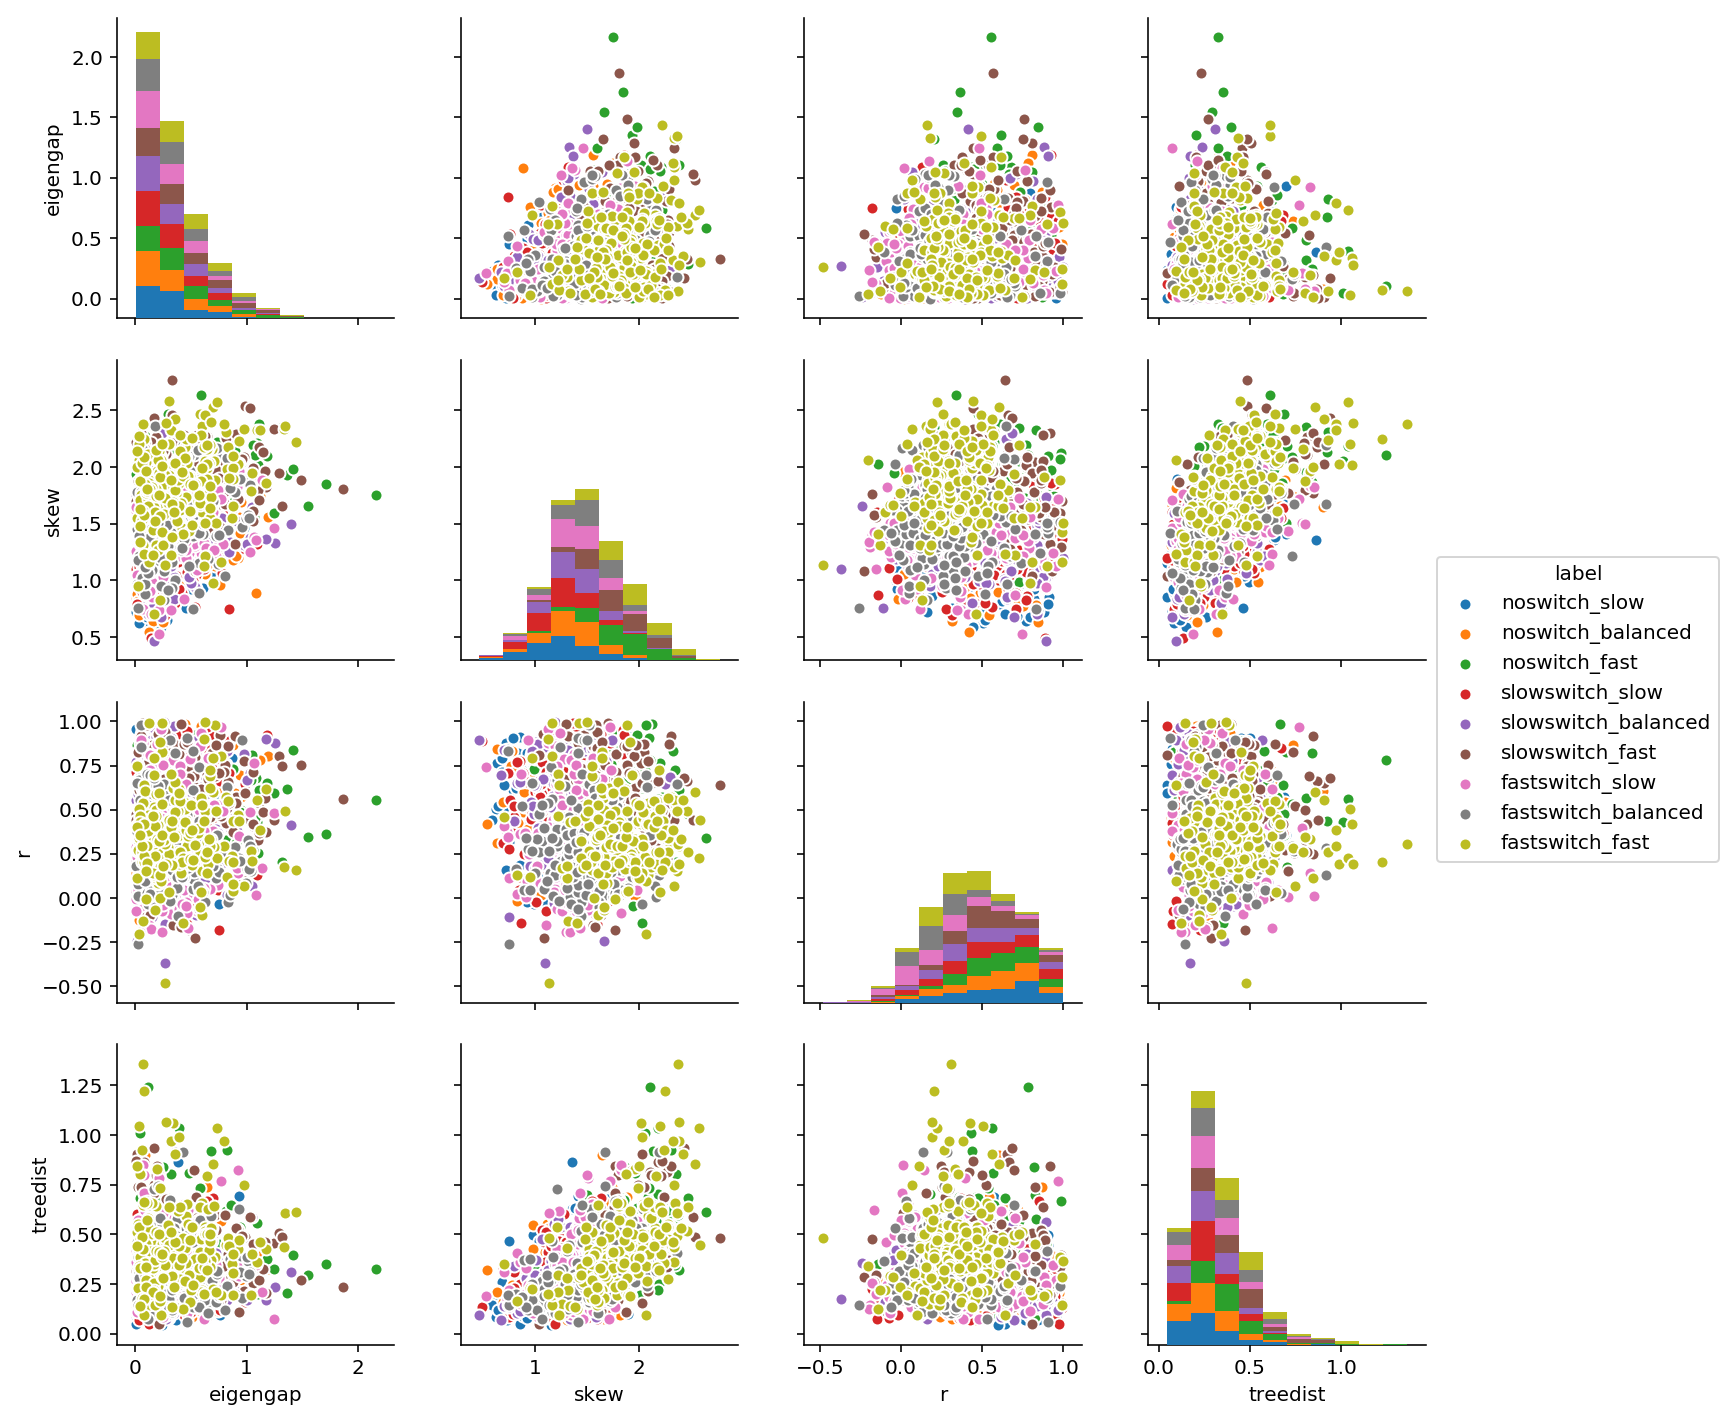

In [64]:
seaborn.pairplot( q.dropna(), vars=['eigengap', 'skew', 'r', 'treedist',], hue='label' )

We expepect that as the spectral distance between the tree components of a graph increases
(indicating more dissimilar tree topology), the Hommola correlation of the interaction graph
should decrease. They are indeed inversely correlated, though not strongly so (r=-0.08, p=0.0008).

(-0.07869711207801403, 0.0008382657292578823)


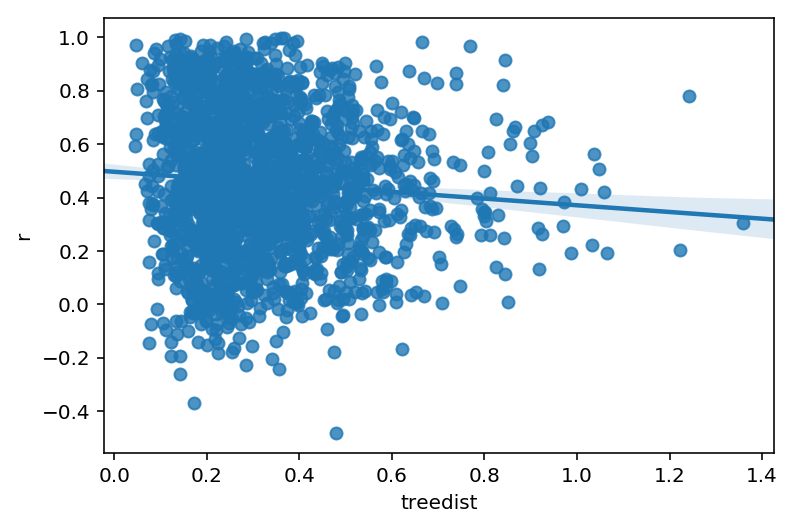

In [29]:
seaborn.regplot( x='treedist', y='r', data=q.dropna() )
print pearsonr( q.dropna().treedist, q.dropna().r ) 

## Clustering with spectral distances

In [9]:
from pyprind import ProgBar

p = ProgBar( len(spectra)**2, title='calculating spectral distances...' )

s_d = zeros( ( len( spectra ), len( spectra ) ) )
for i in range( s_d.shape[0] ) :
    for j in range( s_d.shape[1] ) :
        p.update()
        s_d[i,j] = sqrt( 0.5 * ( entropy( spectra[i], spectra[j] ) + entropy( spectra[j], spectra[i] ) ) )

calculating spectral distances...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:28


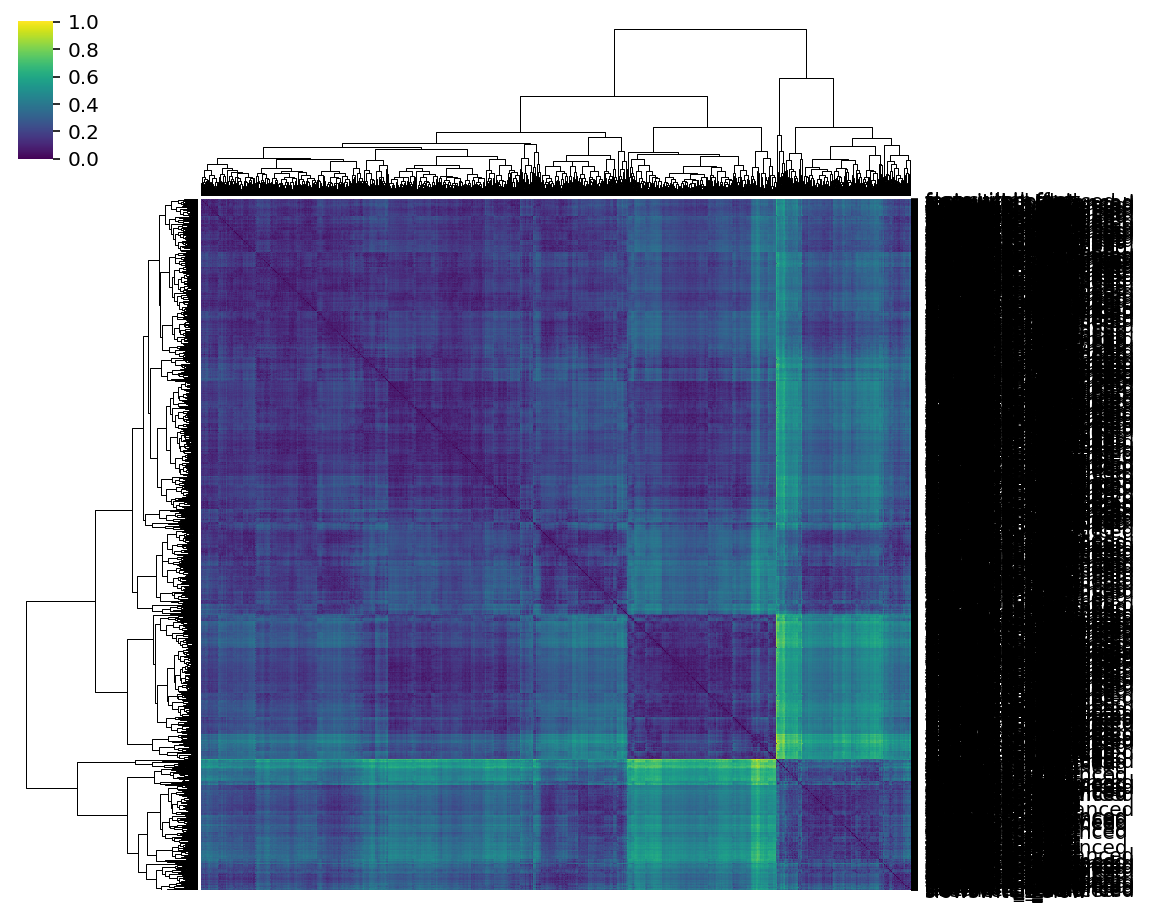

In [65]:
seaborn.clustermap( s_d, cmap='viridis', method='weighted', metric='euclidean', #metric='correlation',
                    figsize=(8,8), xticklabels=False, yticklabels=q.label )

In [26]:
from sklearn.manifold import TSNE, MDS, Isomap

sd_embedded = pandas.DataFrame( TSNE(n_components=2, perplexity=300).fit_transform( s_d ), 
                                columns=['tSNEx','tSNEy'] )
#sd_embedded = pandas.DataFrame( MDS(n_components=2, metric=True ).fit_transform( s_d ), 
#                                columns=['MDSx','MDSy'] )
#sd_embedded = pandas.DataFrame( Isomap(n_components=2 ).fit_transform( s_d ), 
#                                columns=['Isox','Isoy'] )

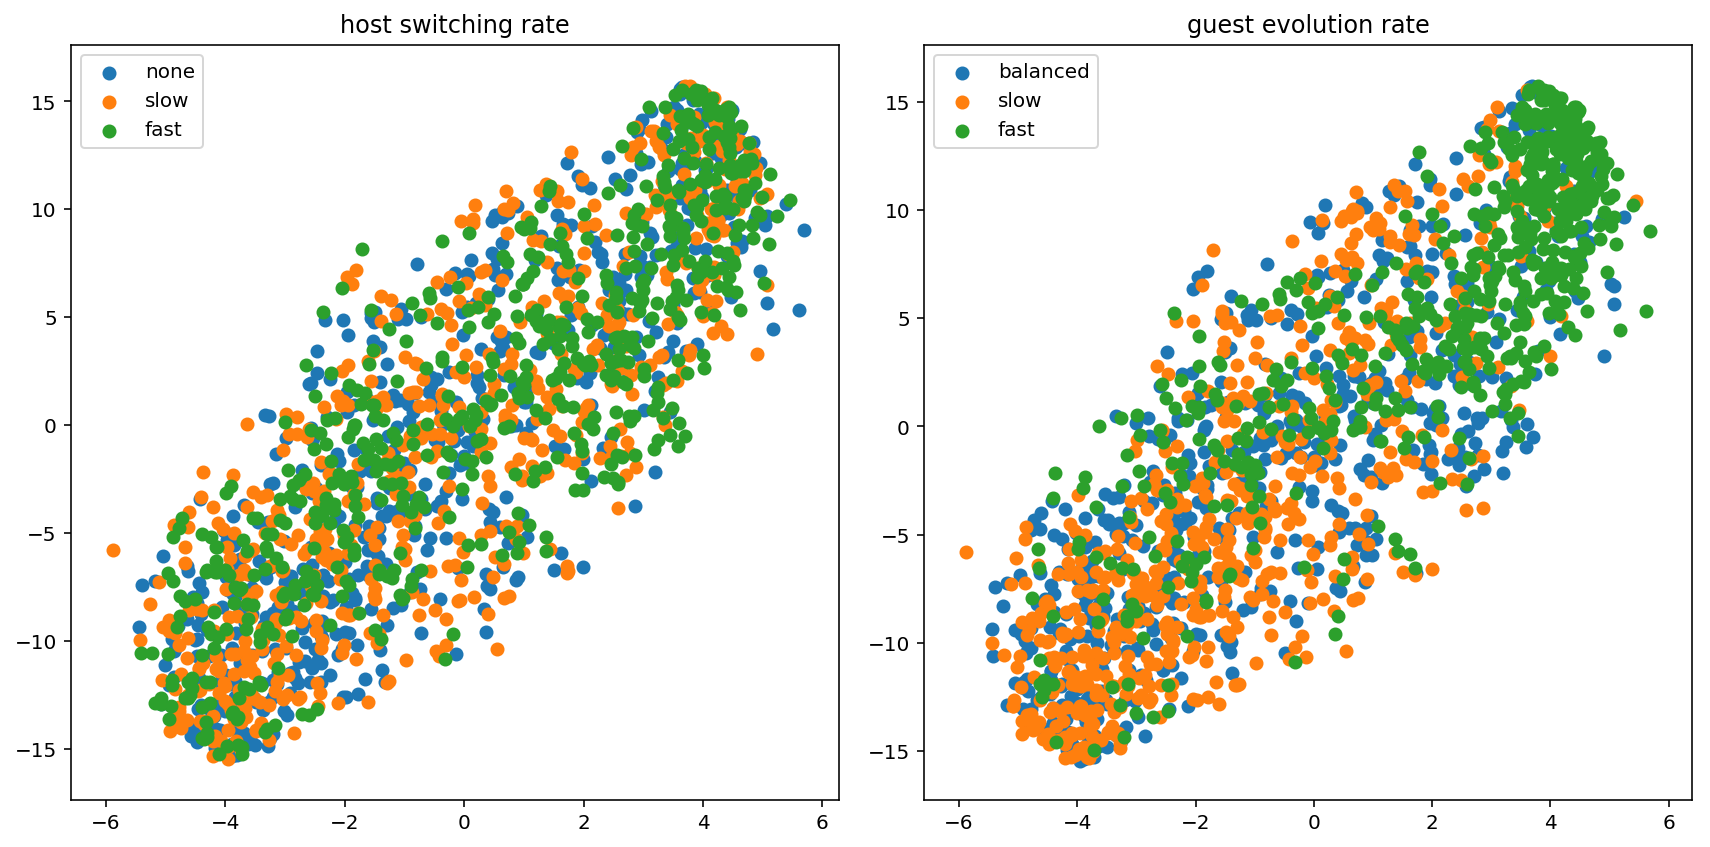

In [27]:
figure( figsize=(12,6) )

qq = q.join( sd_embedded )

subplot(1,2,1)
title( 'host switching rate' )
for l in set( qq.switch ) :
    scatter( qq[qq.switch==l]['tSNEx'], qq[qq.switch==l]['tSNEy'], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

subplot(1,2,2)
title( 'guest evolution rate' )
for l in set( qq.g_evol ) :
    scatter( qq[qq.g_evol==l]['tSNEx'], qq[qq.g_evol==l]['tSNEy'], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

tight_layout()

## Clustering with graph kernels

In [138]:
import graphkernels.kernels as gk

g = gk.CalculateConnectedGraphletKernel( igraphs )
#g = gk.CalculateGraphletKernel( igraphs )

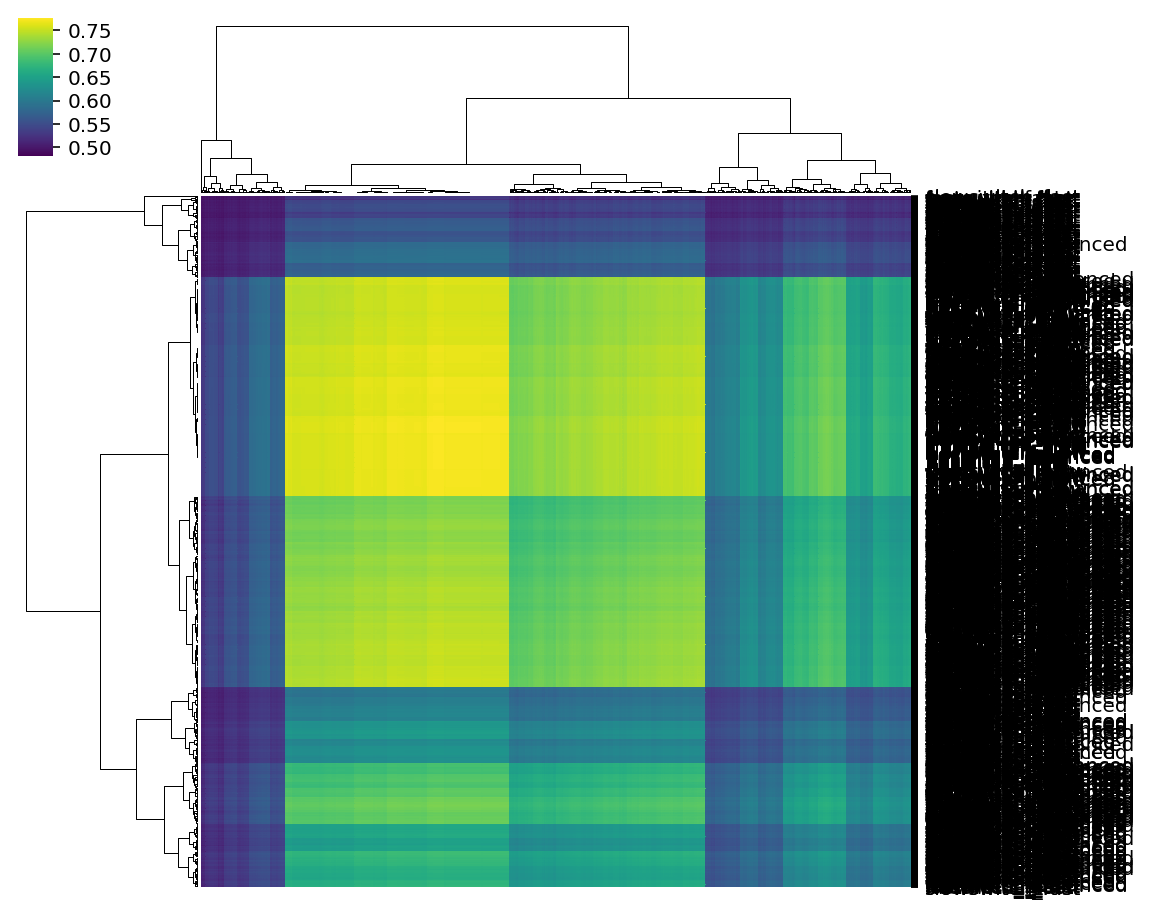

In [155]:
seaborn.clustermap( g, cmap='viridis', method='weighted', metric='euclidean',
                    figsize=(8,8), xticklabels=False, yticklabels=q.label )

Supposing that we treat graph kernels as products, owing to their basis in the direct product, we might
construct a distance measure from the graph kernel like so.

$g_k( A, B ) = AB$

$d( A, B ) = \sqrt{ A^2 + B^2 } = \sqrt{ \frac{A^2B^2}{B^2} + \frac{A^2B^2}{A^2} }$

$d_K( A, B ) = \sqrt{ \frac{g_k( A, B )^2}{ g_k( A, A ) } + \frac{g_k( A, B )^2}{ g_k( B, B ) } }$

In [166]:
d_k = zeros( g.shape )
for i in range( g.shape[0] ) :
    for j in range( g.shape[1] ) :
        #d_k[i,j] = sqrt( g[i,j]**2 / g[j,j] + g[i,j]**2 / g[i,i] )
        d_k[i,j] = sqrt( g[i,j]**2 + 

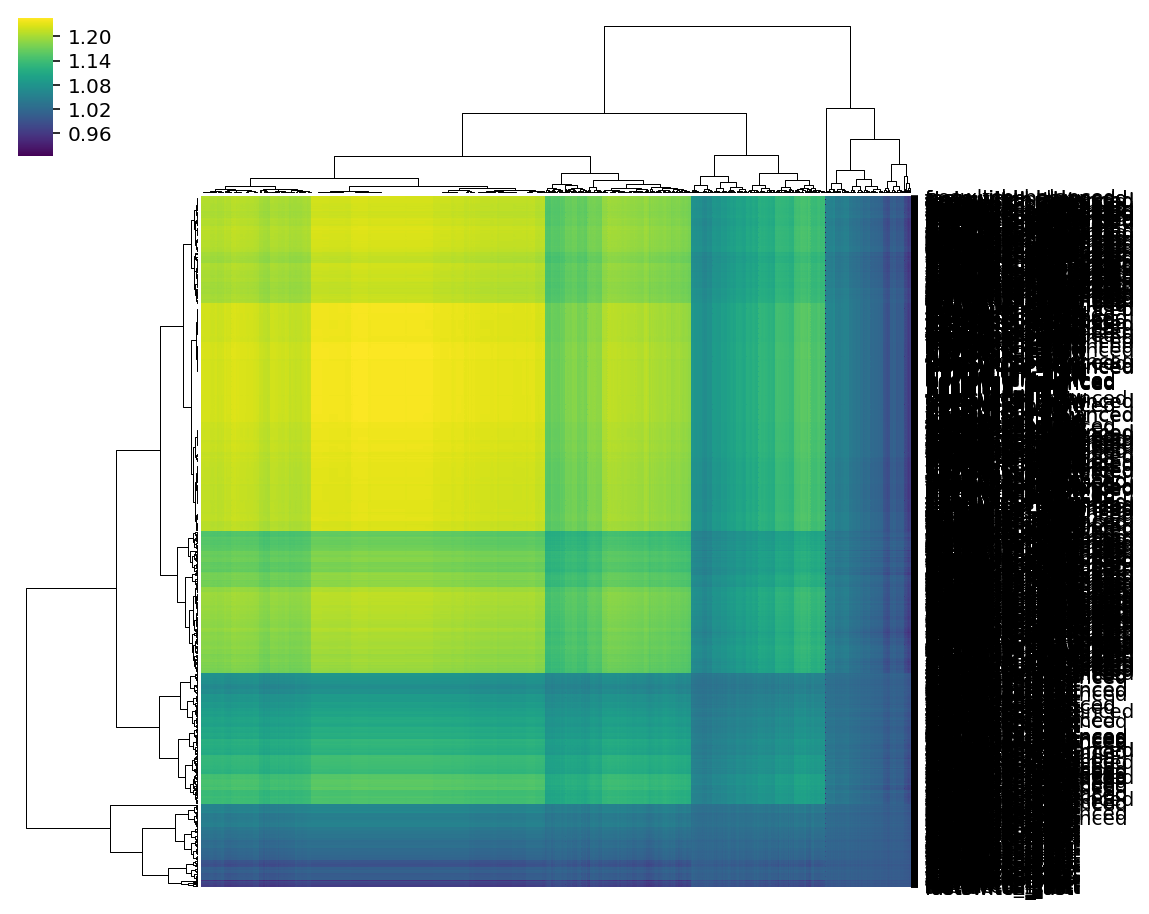

In [167]:
seaborn.clustermap( d_k, cmap='viridis', method='weighted', metric='euclidean',
                    figsize=(8,8), xticklabels=False, yticklabels=q.label )

In [140]:
from sklearn.manifold import TSNE

g_embedded = TSNE(n_components=2, perplexity=30).fit_transform( g )

In [141]:
qq = pandas.DataFrame(g_embedded, columns=['tSNEx','tSNEy']).join(q)

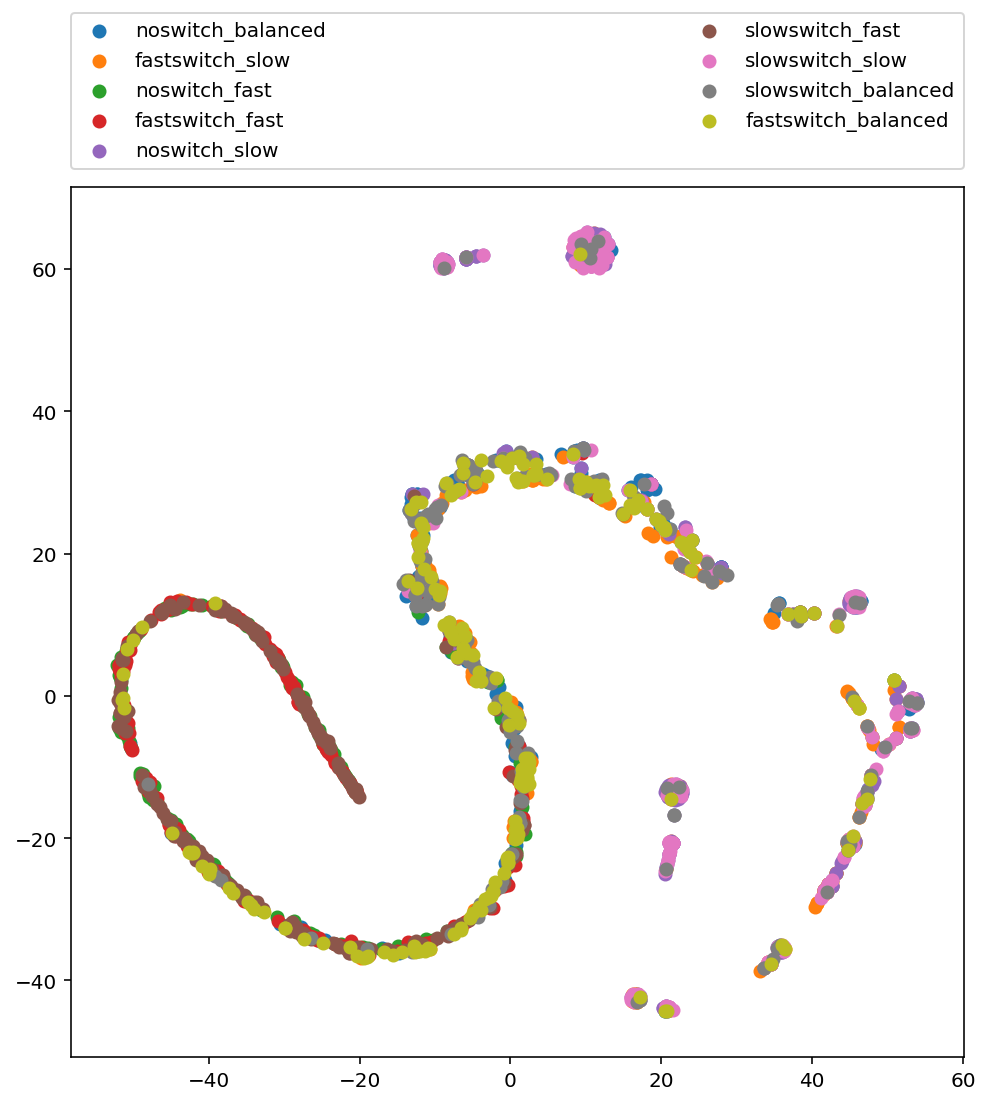

In [142]:
figure( figsize=(8,8) )
for l in set( qq.label ) :
    scatter( qq[qq.label==l]['tSNEx'], qq[qq.label==l]['tSNEy'], label=l )
legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0. )

In [120]:
qqqq = pandas.DataFrame(q_embedded, columns=['tSNEx','tSNEy']).join(qqq).join(q.loc[qqq.index][['label','switch','g_evol']])

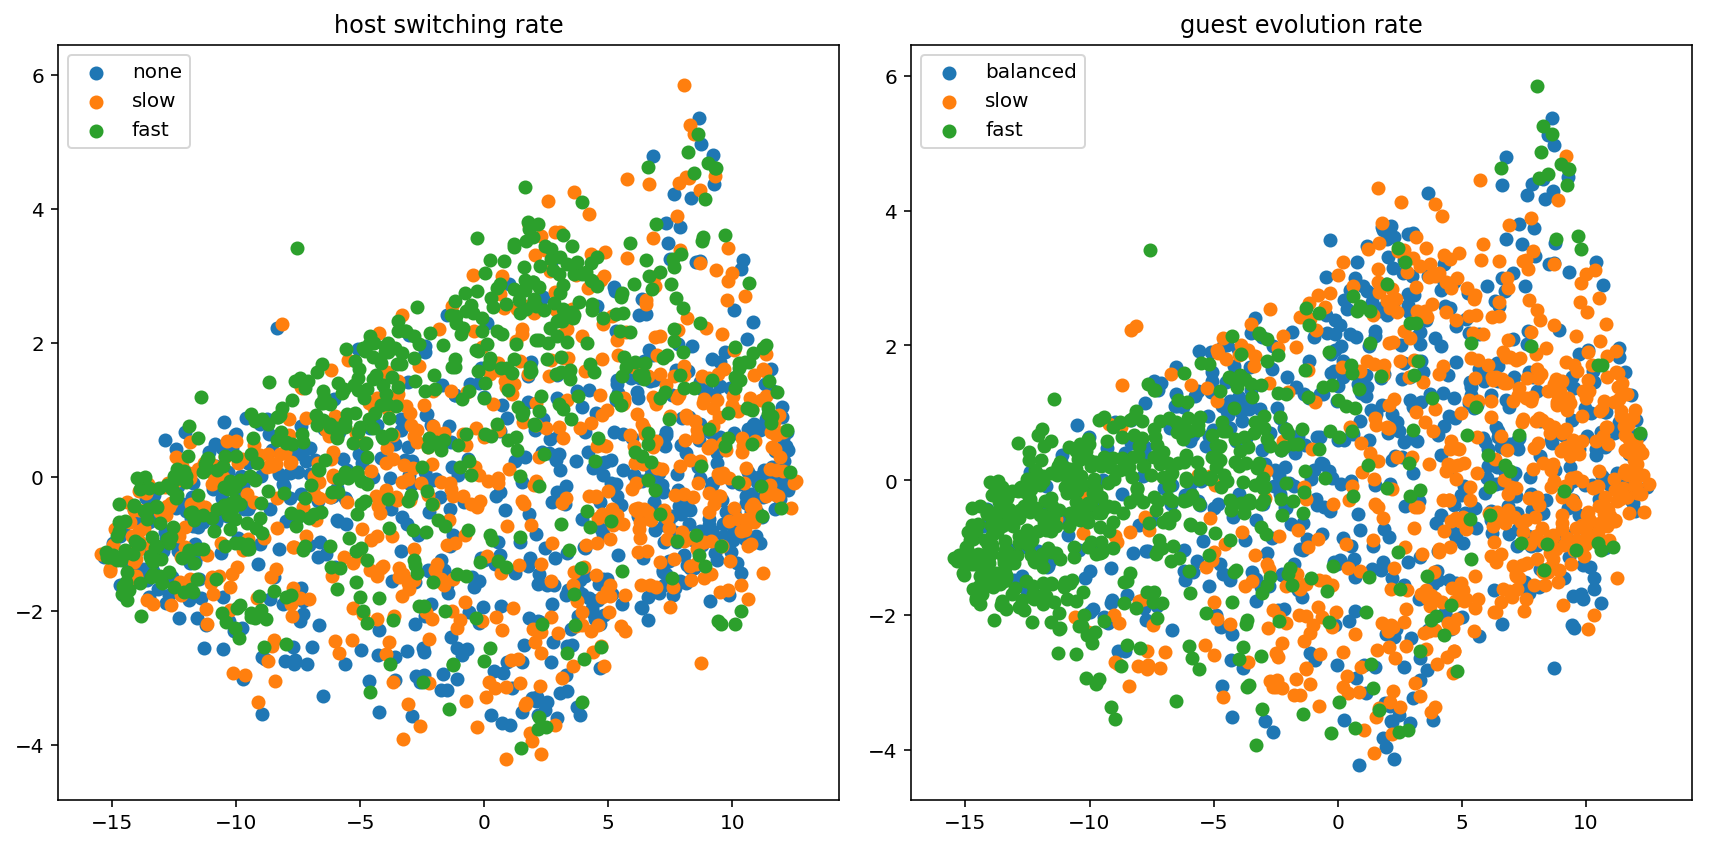

In [134]:
figure( figsize=(12,6) )

subplot(1,2,1)
title( 'host switching rate' )
for l in set( qq.switch ) :
    scatter( qqqq[qqqq.switch==l]['tSNEx'], qqqq[qqqq.switch==l]['tSNEy'], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

subplot(1,2,2)
title( 'guest evolution rate' )
for l in set( qq.g_evol ) :
    scatter( qqqq[qqqq.g_evol==l]['tSNEx'], qqqq[qqqq.g_evol==l]['tSNEy'], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

tight_layout()

Feature ranking:
1. feature 4 (0.191979)
2. feature 6 (0.148260)
3. feature 1 (0.139269)
4. feature 5 (0.134844)
5. feature 2 (0.134095)
6. feature 0 (0.126191)
7. feature 3 (0.125362)


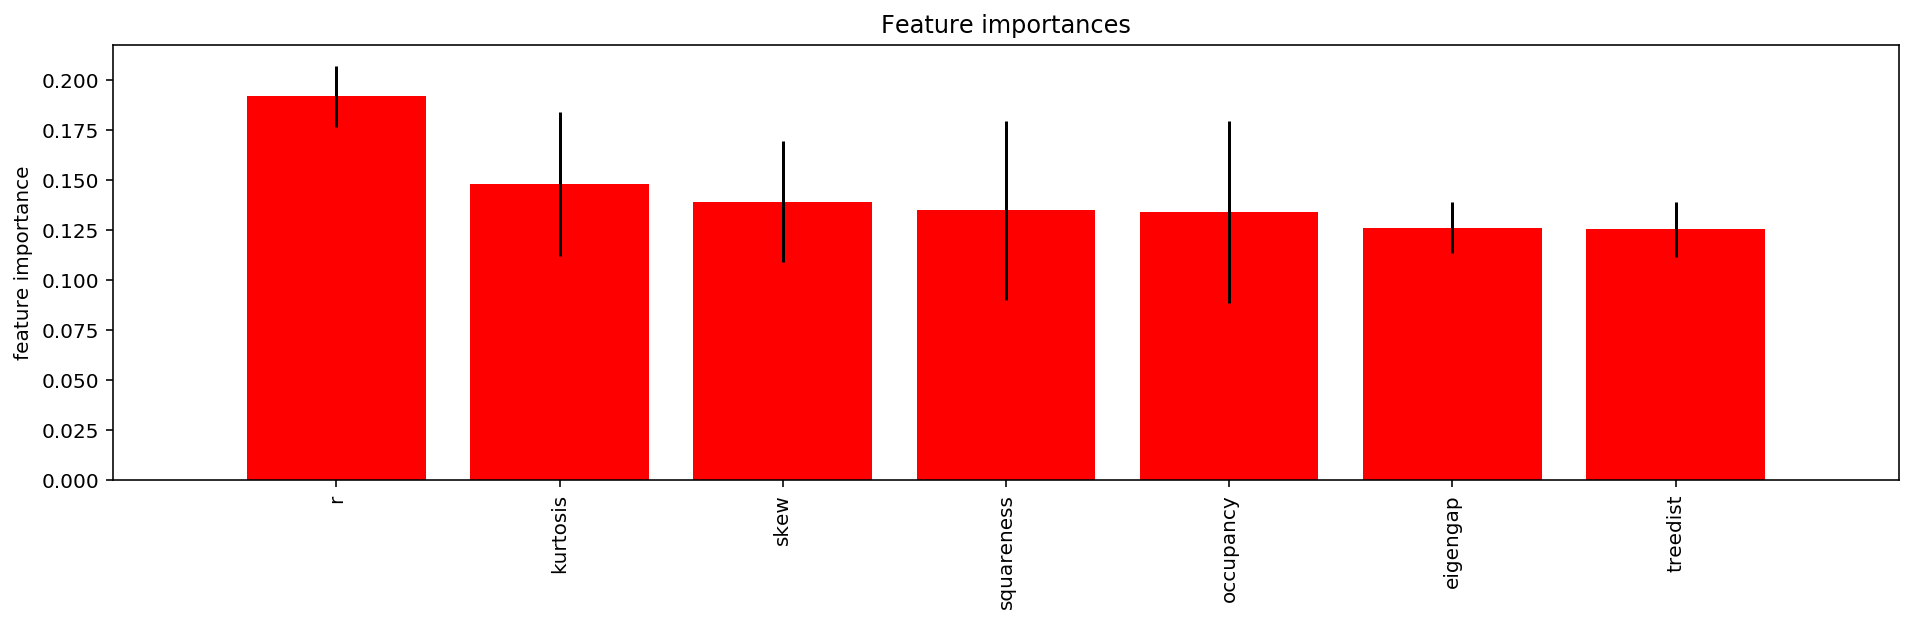

In [115]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

X = qqq
y = q.loc[qqq.index][['g_evol', 'switch']]

forest = RandomForestClassifier( n_estimators=1000,
                                 criterion='gini',
                                 random_state=0,
                                 n_jobs=4 )

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
#plt.figure()
figure( figsize=(16,4) )
title("Feature importances")
bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
xticks(range(X.shape[1]), X.columns[indices], rotation='vertical')
xlim([-1, X.shape[1]])
ylabel('feature importance')